In [1]:
import pickle

import sys
sys.path.append('../../src/')
from explainer.explainer import Explainer

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
with open('model/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)
with open('model/model.pkl', 'rb') as f:
    model = pickle.load(f)

In [3]:
with open('results_baseline.pkl', 'rb') as f:
    results_baseline = pickle.load(f)
with open('results_prototype.pkl', 'rb') as f:
    results_prototype = pickle.load(f)
with open('results.pkl', 'rb') as f:
    results_novel = pickle.load(f)

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def calculate_l_k_norm(initial, final, k):
    return (sum([abs(final[i] - initial[i])**k for i in range(len(initial))]))**(1/k)

In [5]:
baseline_L1_distances = []
prototype_L1_distances = []
novel_L1_distances = []

baseline_L2_distances = []
prototype_L2_distances = []
novel_L2_distances = []

baseline_features_changed = []
prototype_features_changed = []
novel_features_changed = []

for data_id in results_novel.keys():
    original_data = training_data.iloc[data_id].values[:-1]
    baseline_counterfactual = results_baseline[data_id].data['cf']['X'][0]
    prototype_counterfactual = results_prototype[data_id].data['cf']['X'][0]
    
    novel_counterfactual = results_novel[data_id][1].explanation_point
    novel_counterfactual[results_novel[data_id][1].explainable_variable] = results_novel[data_id][1].get_arg_extrema()
    novel_counterfactual = novel_counterfactual.values

    baseline_L1_distances.append(calculate_l_k_norm(original_data, baseline_counterfactual, 1))
    prototype_L1_distances.append(calculate_l_k_norm(original_data, prototype_counterfactual, 1))
    novel_L1_distances.append(calculate_l_k_norm(original_data, novel_counterfactual, 1))

    baseline_L2_distances.append(calculate_l_k_norm(original_data, baseline_counterfactual, 2))
    prototype_L2_distances.append(calculate_l_k_norm(original_data, prototype_counterfactual, 2))
    novel_L2_distances.append(calculate_l_k_norm(original_data, novel_counterfactual, 2))

    baseline_features_changed.append(sum([1 if original_data[i] != baseline_counterfactual[i] else 0 for i in range(len(original_data))]))
    prototype_features_changed.append(sum([1 if original_data[i] != prototype_counterfactual[i] else 0 for i in range(len(original_data))]))
    novel_features_changed.append(sum([1 if original_data[i] != novel_counterfactual[i] else 0 for i in range(len(original_data))]))


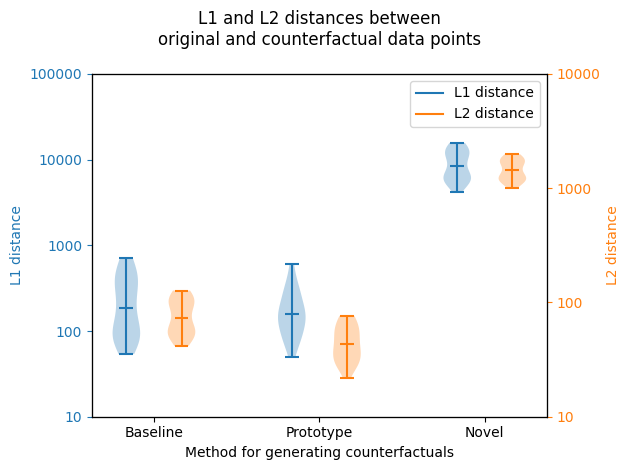

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.violinplot(
    [
        np.log(np.array(baseline_L1_distances)), 
        np.log(np.array(prototype_L1_distances)), 
        np.log(np.array(novel_L1_distances))
    ], 
    showmeans=True,
    positions = [1, 4, 7]
)
ax1.set_xticks([1.5, 4.5, 7.5], ['Baseline', 'Prototype', 'Novel'])
ax1.set_yticks(
    np.log(
        np.array(
            [10, 100, 1000, 10000, 100000]
        )
    ), 
    [10, 100, 1000, 10000, 100000]
)

ax2.plot([], [])
ax2.violinplot(
    [
        np.log(np.array(baseline_L2_distances)), 
        np.log(np.array(prototype_L2_distances)), 
        np.log(np.array(novel_L2_distances))
    ], 
    showmeans=True,
    positions = [2, 5, 8]
)
ax2.set_yticks(
    np.log(
        np.array(
            [10, 100, 1000, 10000]
        )
    ), 
    [10, 100, 1000, 10000]
)


ax1.set_ylabel('L1 distance')
ax1.yaxis.label.set_color('C0')
ax1.yaxis.set_tick_params(color='C0', labelcolor='C0')

ax2.set_ylabel('L2 distance')
ax2.yaxis.label.set_color('C1')
ax2.yaxis.set_tick_params(color='C1', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot([], [], label='L1 distance', color='C0')
ax3.plot([], [], label='L2 distance', color='C1')

ax1.set_xlabel('Method for generating counterfactuals')

ax3.legend()
ax3.set_yticks([])

plt.title('L1 and L2 distances between\noriginal and counterfactual data points\n')
plt.tight_layout()

plt.savefig('../../figures/counterfactual_distances.pdf')

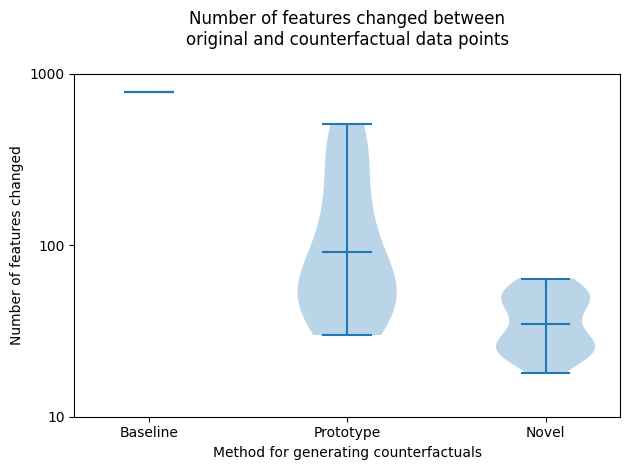

In [7]:
plt.violinplot(
    [
        np.log(np.array(baseline_features_changed)), 
        np.log(np.array(prototype_features_changed)), 
        np.log(np.array(novel_features_changed))
    ], 
    showmeans=True,
)

plt.xticks([1, 2, 3], ['Baseline', 'Prototype', 'Novel'])
plt.yticks(
    np.log(
        np.array(
            [10, 100, 1000]
        )
    ), 
    [10, 100, 1000]
)
plt.ylabel('Number of features changed')
plt.xlabel('Method for generating counterfactuals')
plt.title('Number of features changed between\noriginal and counterfactual data points\n')
plt.tight_layout()
plt.savefig('../../figures/counterfactual_features_changed.pdf')

In [10]:
print(np.mean(novel_features_changed))
print(np.mean(prototype_features_changed))
print(np.mean(baseline_features_changed))

37.28
140.12
781.88
